# Exploring Weather Trends

For the Udacity Data Analyst Nanodegree

By Ken Norton, 2019

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

In [2]:
plt.style.use('fivethirtyeight')
plt.style.use('seaborn-poster')

## Extract the data from the database

Schema:

* `city_list` - This contains a list of cities and countries in the database. Look through them in order to find the city nearest to you.
* `city_data` - This contains the average temperatures for each city by year (&deg;C).
* `global_data` - This contains the average global temperatures by year (&deg;C).

First I checked to see how granular the data was:

```SQL
SELECT
  city 
FROM
  city_list
WHERE
  country = 'United States';
```

I determined that the database only includes major U.S. cities. San Francisco is my nearest city in the database.

```SQL
SELECT
  *
FROM
  city_data
WHERE
  city = 'San Francisco';
```

I downloaded the results for SF into a CSV called `sanfrancisco.csv`

```SQL
SELECT
  * 
FROM
  global_data;
```

I downloaded the results for global temperatures into a CSV called `global.csv`

## Import the data

In [3]:
# Import data from the CSVs into dataframes
sf_temp = pd.read_csv('data/sanfrancisco.csv')
global_temp = pd.read_csv('data/global.csv')

In [4]:
sf_temp.describe()

,year,avg_temp
count,165.000000,165.000000
mean,1931.000000,14.450788
std,47.775517,0.504885
min,1849.000000,13.220000
25%,1890.000000,14.120000
50%,1931.000000,14.390000
75%,1972.000000,14.760000
max,2013.000000,16.230000


In [5]:
global_temp.describe()

,year,avg_temp
count,266.000000,266.000000
mean,1882.500000,8.369474
std,76.931788,0.584747
min,1750.000000,5.780000
25%,1816.250000,8.082500
50%,1882.500000,8.375000
75%,1948.750000,8.707500
max,2015.000000,9.830000


I note that the global data goes back to 1750 whereas the San Francisco data only goes back to 1849. I decide to merge them into a single dataframe to make comparisons more convenient.

In [6]:
# Merge into a new dataframe called 'temps' that 
# contains columns for global and for SF
temps = pd.merge(global_temp, 
                 sf_temp, 
                 on='year', 
                 how='outer', 
                 suffixes=('_glob', '_sf'))

# Re-index on the year column
temps.set_index('year', inplace=True)

# Drop the city and country columns now that they're not needed
temps = temps.drop(columns=['city', 'country'])

Since I'm based in the US, I find Fahrenheit measurements easier to understand than Celsius. I'm going to convert the data to Fahrenheit using a quick-and-dirty function.

In [7]:
# Quick little function to convert Celsius to Fahrenheit
def c2f(c):
    return (c * 1.8) + 32

In [8]:
# Tests to make sure the function works properly
print(c2f(0), 'Expect: 32')
print(c2f(100), 'Expect: 212')

32.0 Expect: 32
212.0 Expect: 212


I'm going to run the `c2f` function over both temperature columns and update them in place, effectively converting the entire dataframe to Fahrenheit.

In [9]:
temps['avg_temp_glob'] = c2f(temps['avg_temp_glob'])
temps['avg_temp_sf'] = c2f(temps['avg_temp_sf'])

In [10]:
temps.head()

,avg_temp_glob,avg_temp_sf
year,,
1750,47.696,NaN
1751,46.364,NaN
1752,42.404,NaN
1753,47.102,NaN
1754,47.246,NaN


## Create a line chart

That compares your city’s temperatures with the global temperatures. Make sure to plot the moving average rather than the yearly averages in order to smooth out the lines, making trends more observable (the last concept in the previous lesson goes over how to do this in a spreadsheet).

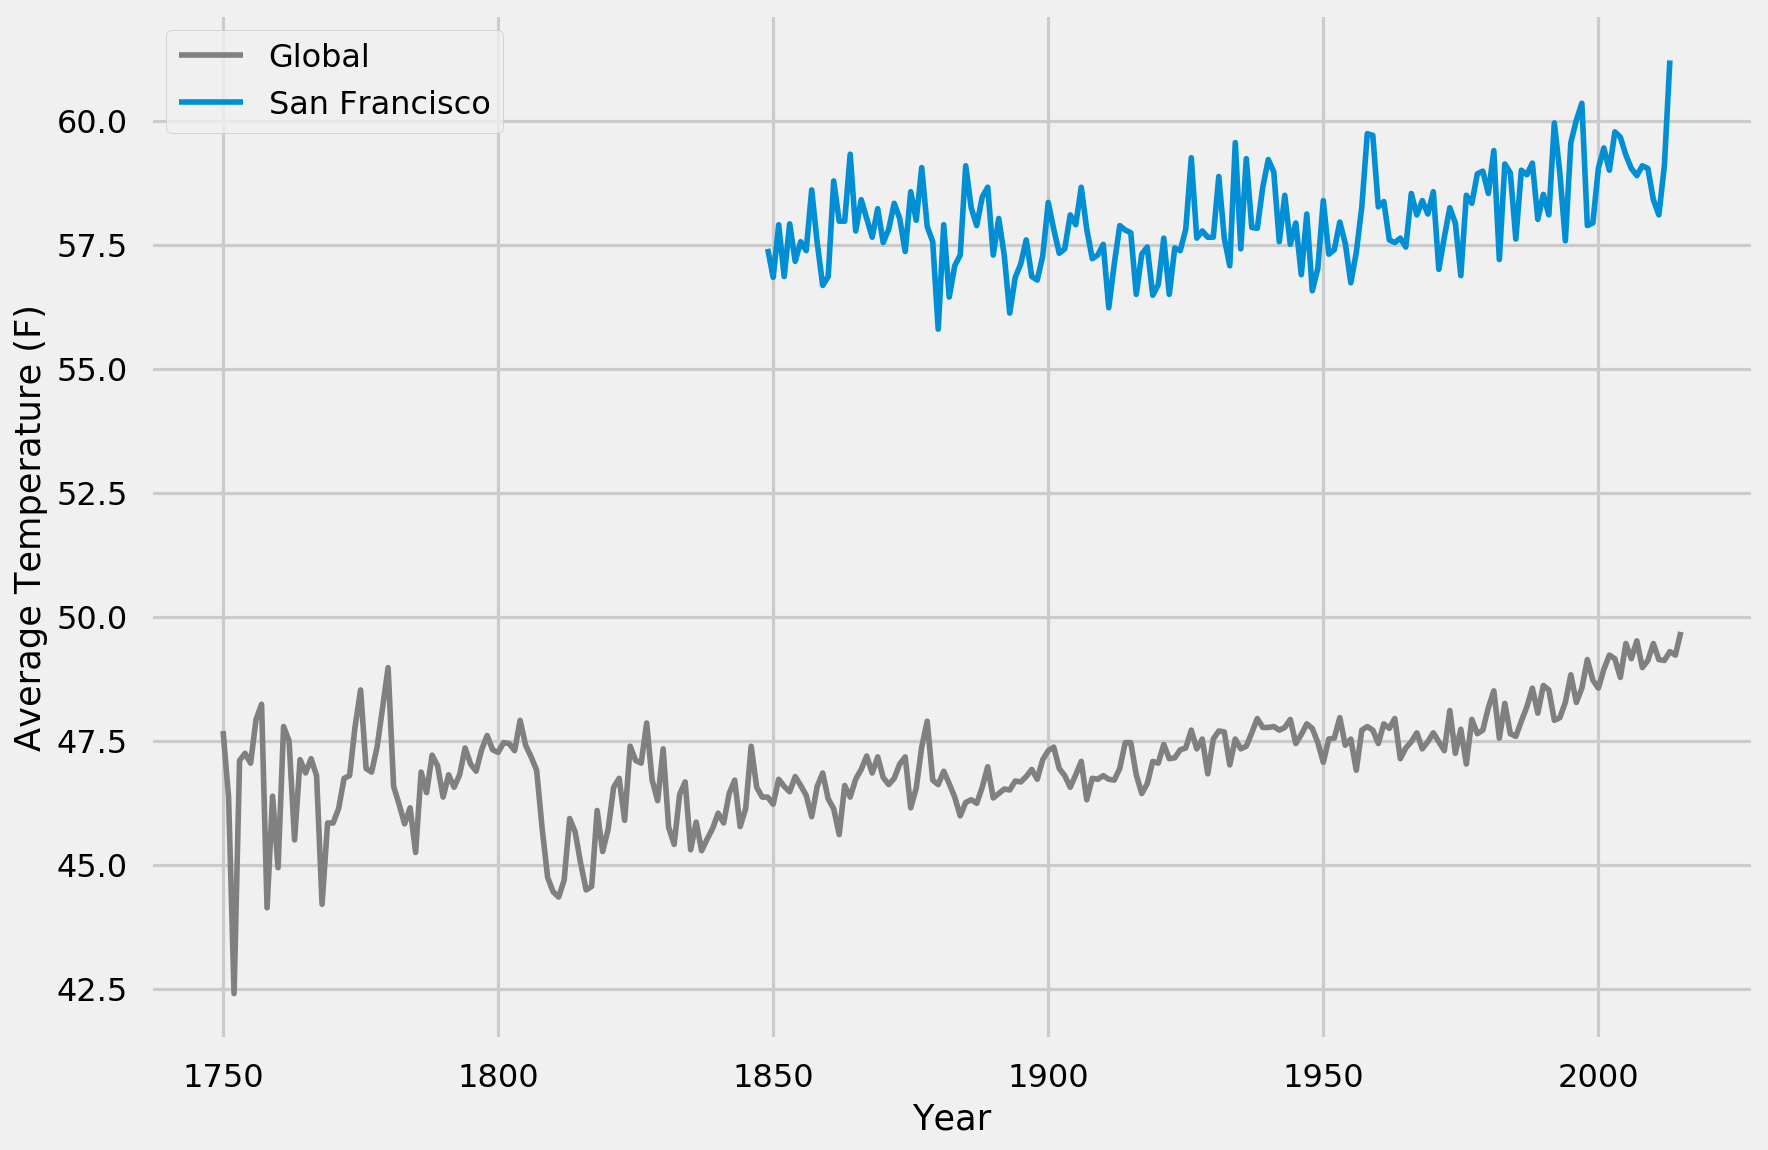

In [11]:
plt.plot(temps['avg_temp_glob'], color='gray', label='Global')
plt.plot(temps['avg_temp_sf'], label='San Francisco')
plt.xlabel('Year')
plt.ylabel('Average Temperature (F)')
plt.legend()
plt.show()

### Weather trends: ten year moving average

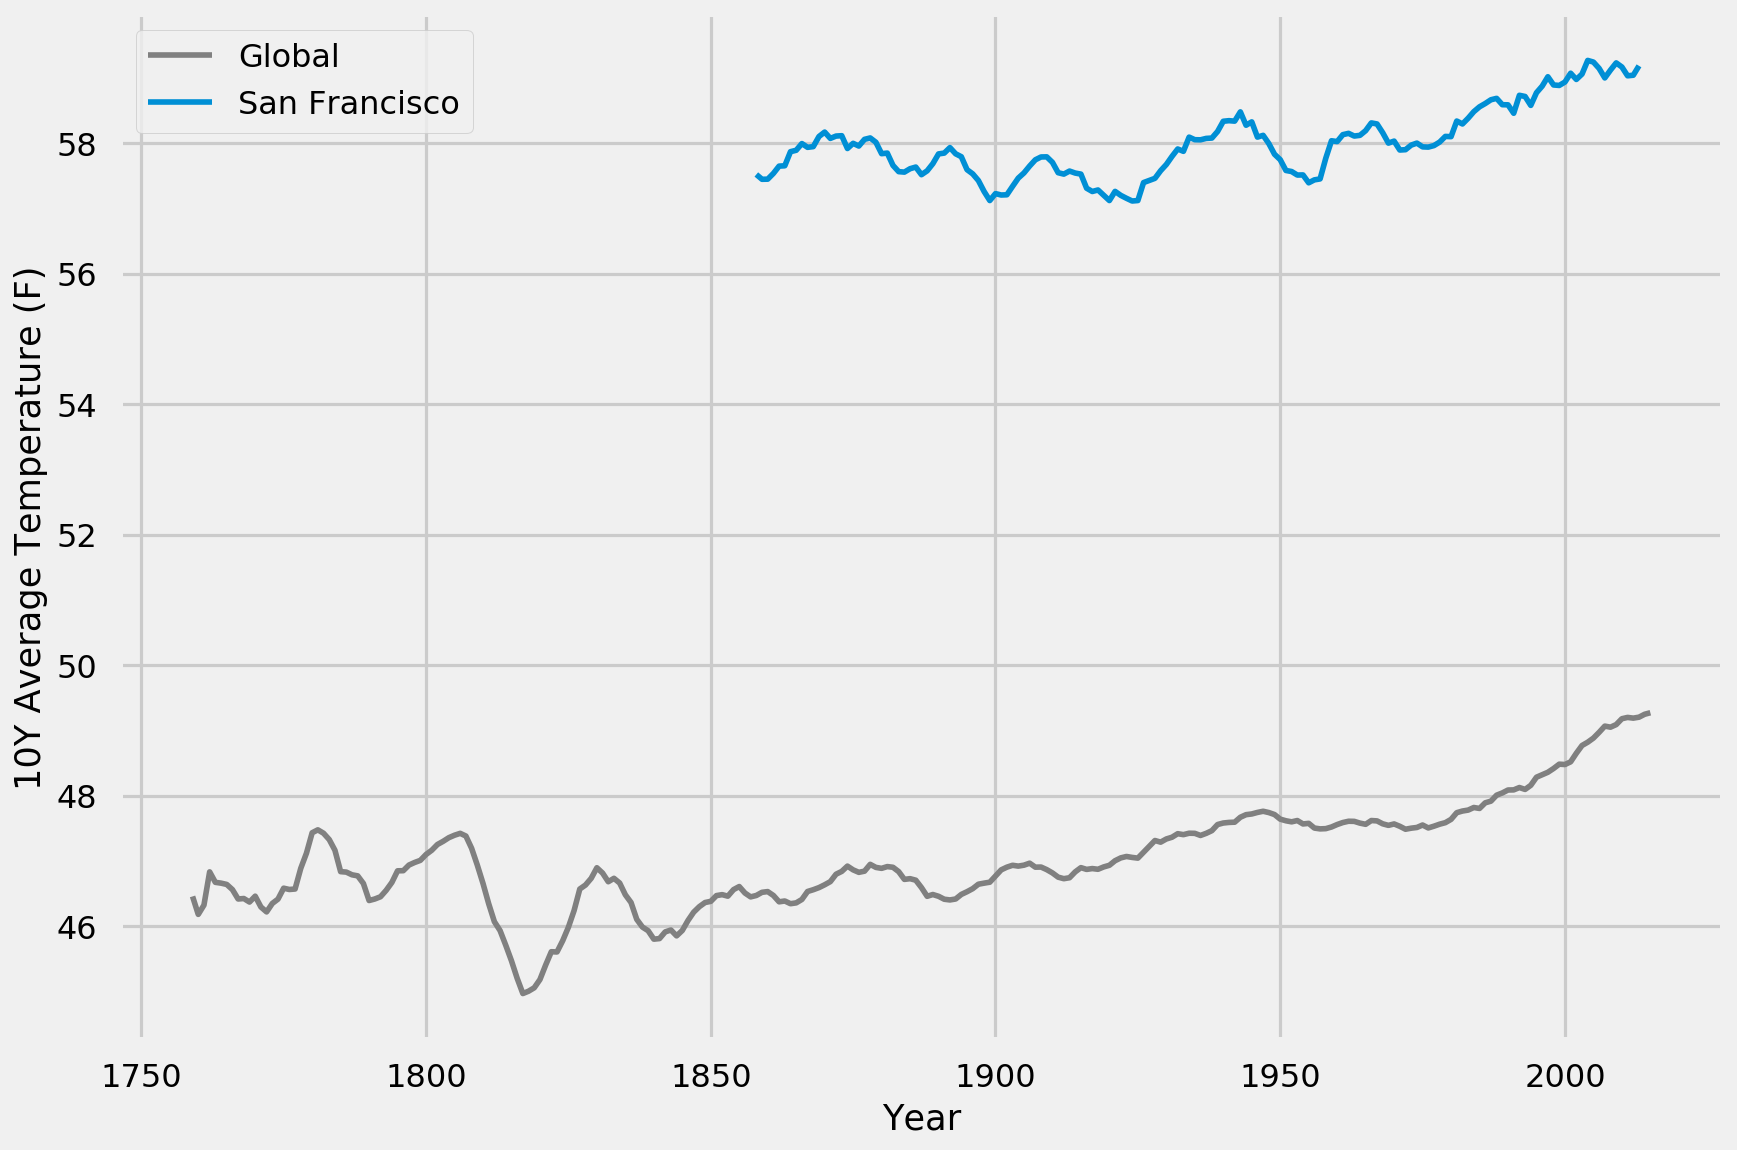

In [12]:
plt.plot(temps['avg_temp_glob']
         .rolling(window=10)
         .mean(), 
         color='gray', 
         label='Global')
plt.plot(temps['avg_temp_sf']
         .rolling(window=10)
         .mean(), 
         label='San Francisco')
plt.xlabel('Year')
plt.ylabel('10Y Average Temperature (F)')
plt.legend()
plt.show()

### Weather trends: fifty year moving average

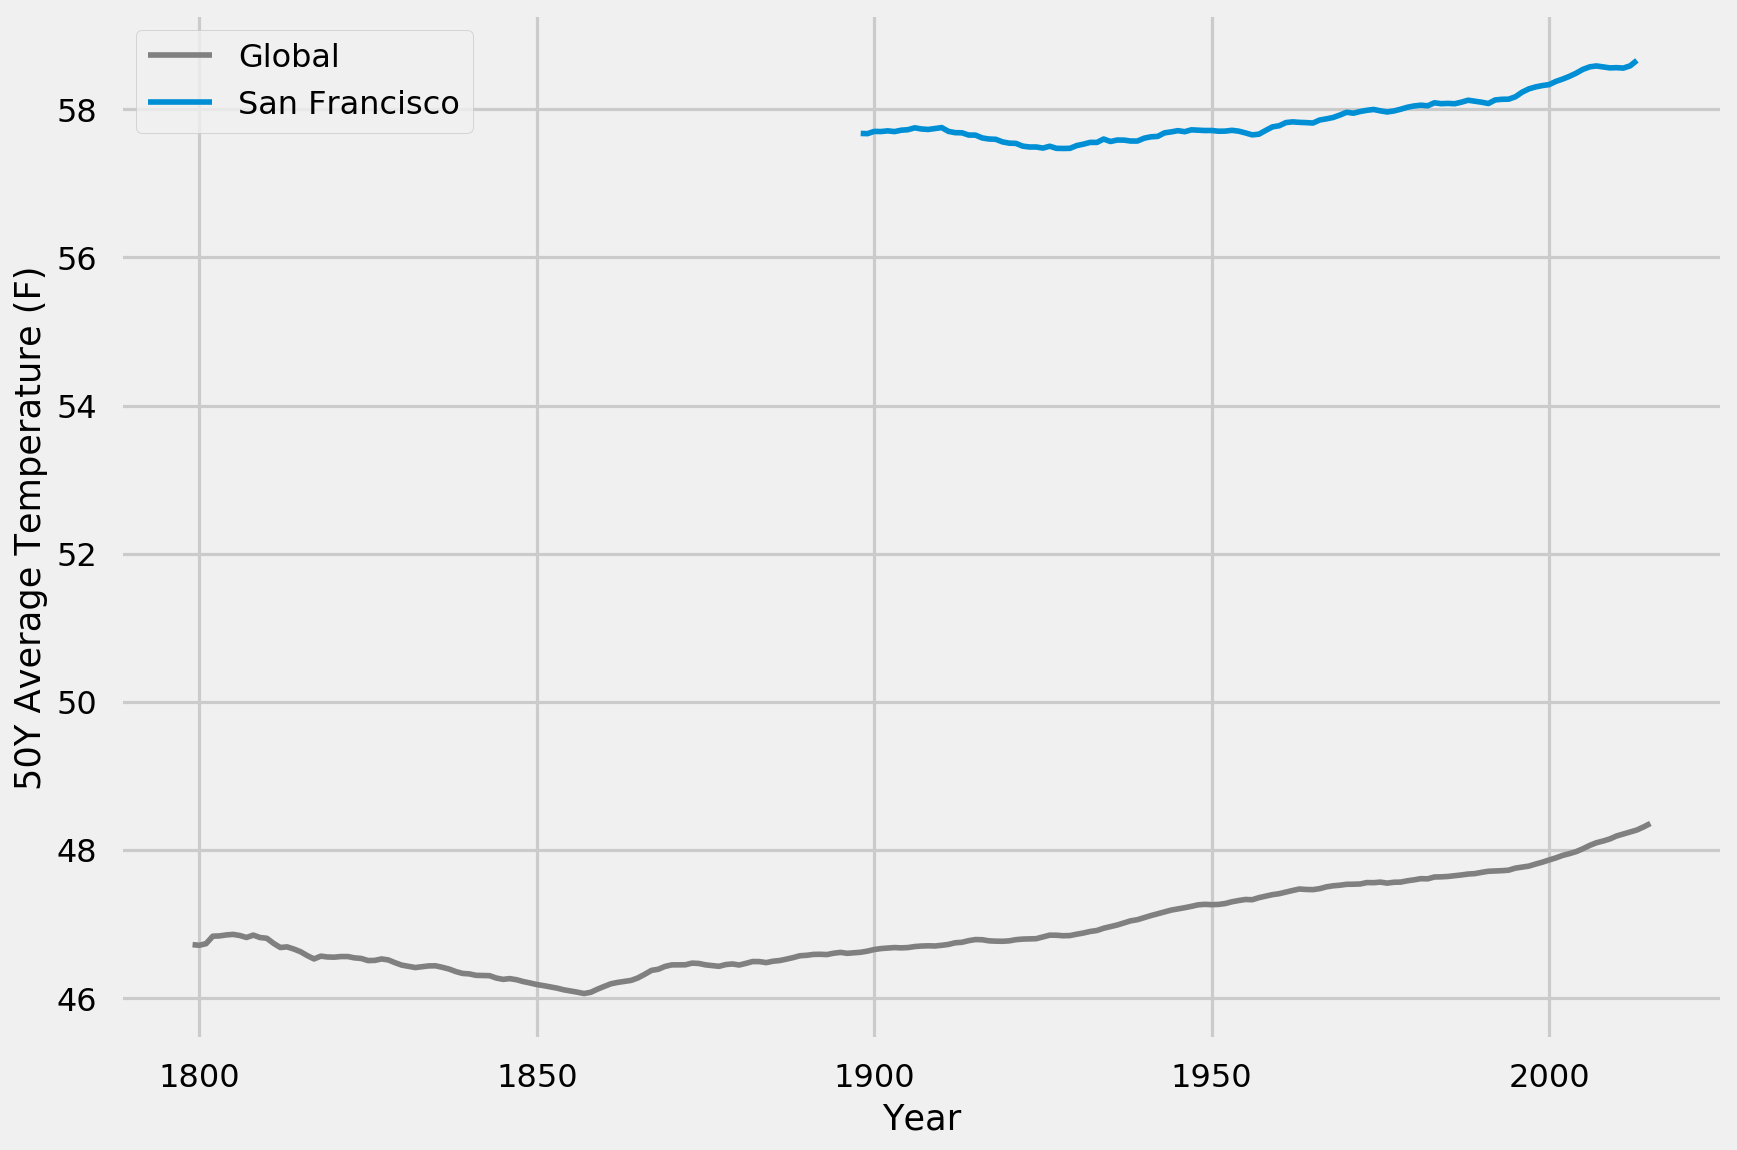

In [13]:
plt.plot(temps['avg_temp_glob']
         .rolling(window=50)
         .mean(), 
         color='gray',
         label='Global')
plt.plot(temps['avg_temp_sf']
         .rolling(window=50)
         .mean(), 
         label='San Francisco')
plt.xlabel('Year')
plt.ylabel('50Y Average Temperature (F)')
plt.legend()
plt.show()

### San Francisco versus the global average

Text(0, 0.5, 'Difference between SF and Global Avg Temp (F)')

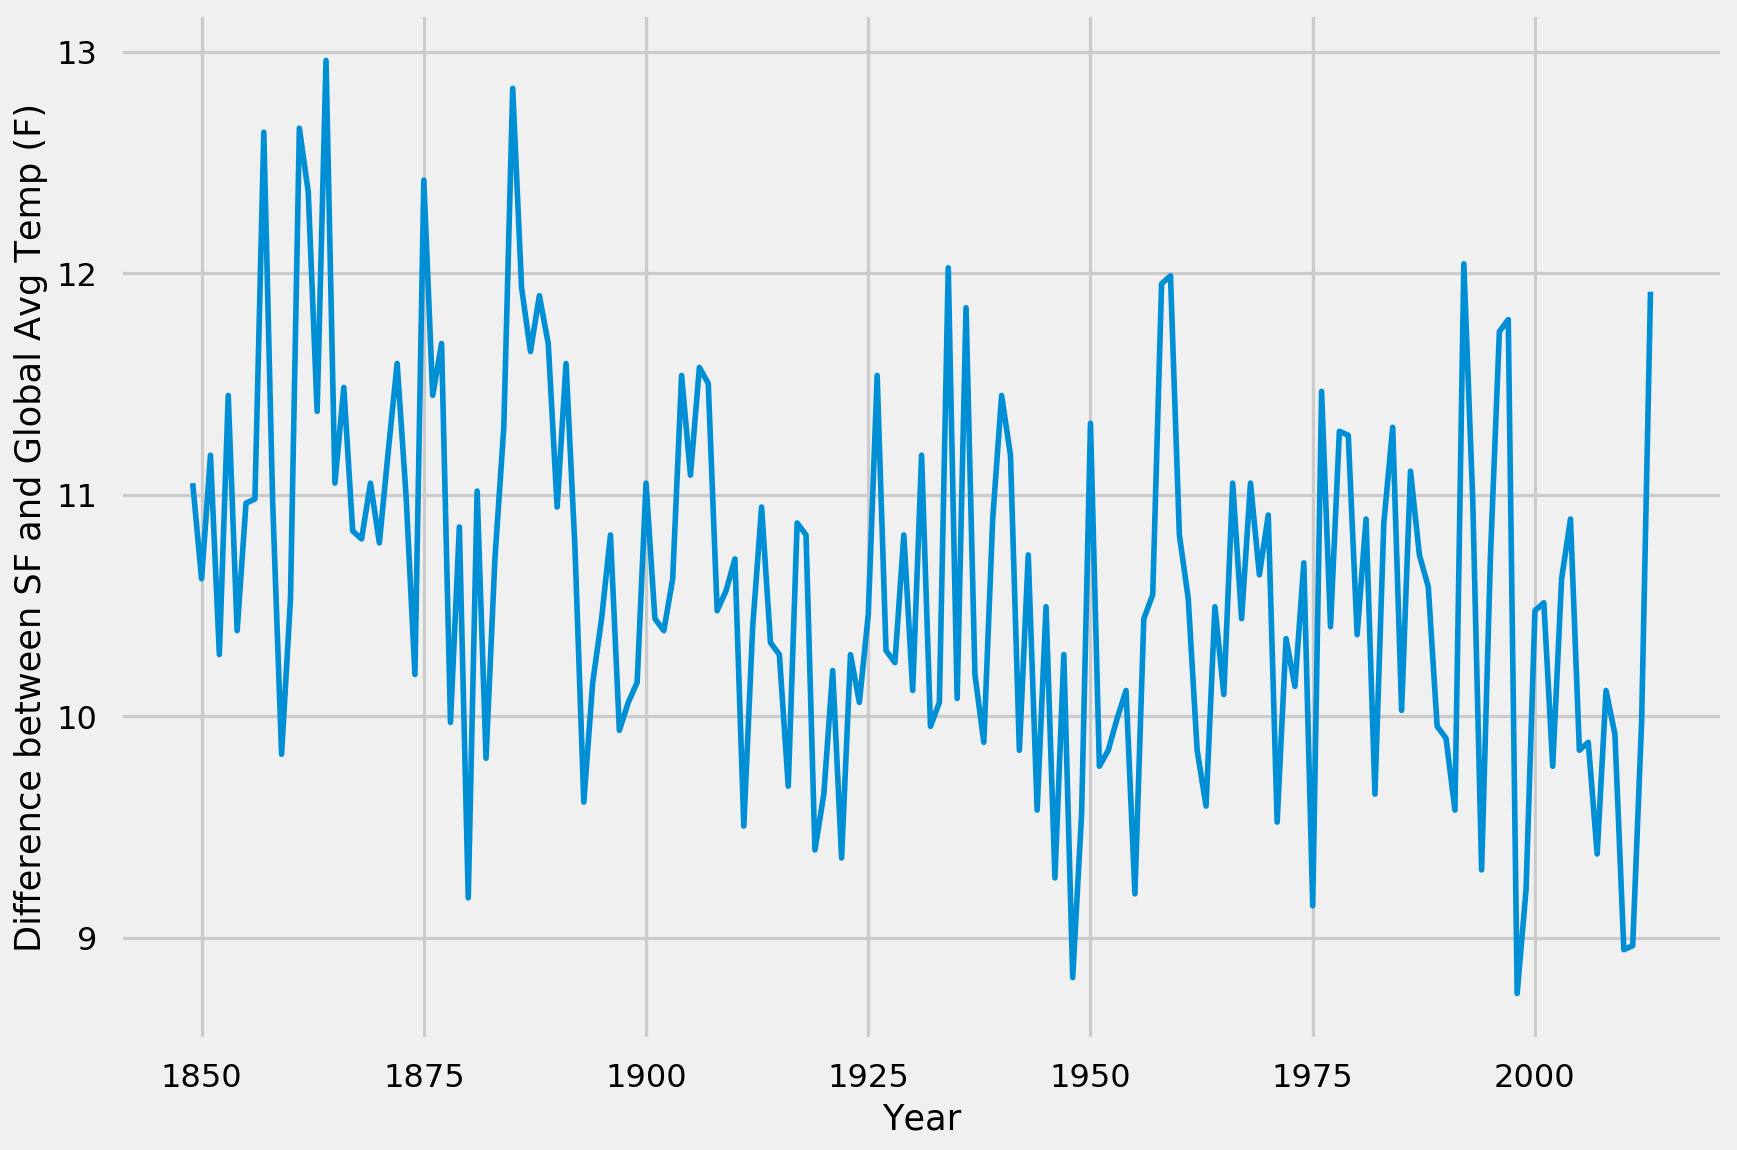

In [14]:
# Plot the difference between SF and global 10-year moving 
# average temperatures
plt.plot(temps['avg_temp_sf'] - temps['avg_temp_glob'])
plt.xlabel('Year')
plt.ylabel('Difference between SF and Global Avg Temp (F)')

We can see that SF is hotter than the global average, varying from between ~9-13 degrees Fahrenheit hotter. Let's use a 10-year average to smooth the lines a bit.

Text(0, 0.5, 'Difference between SF and Global 10Y Avg Temp (F)')

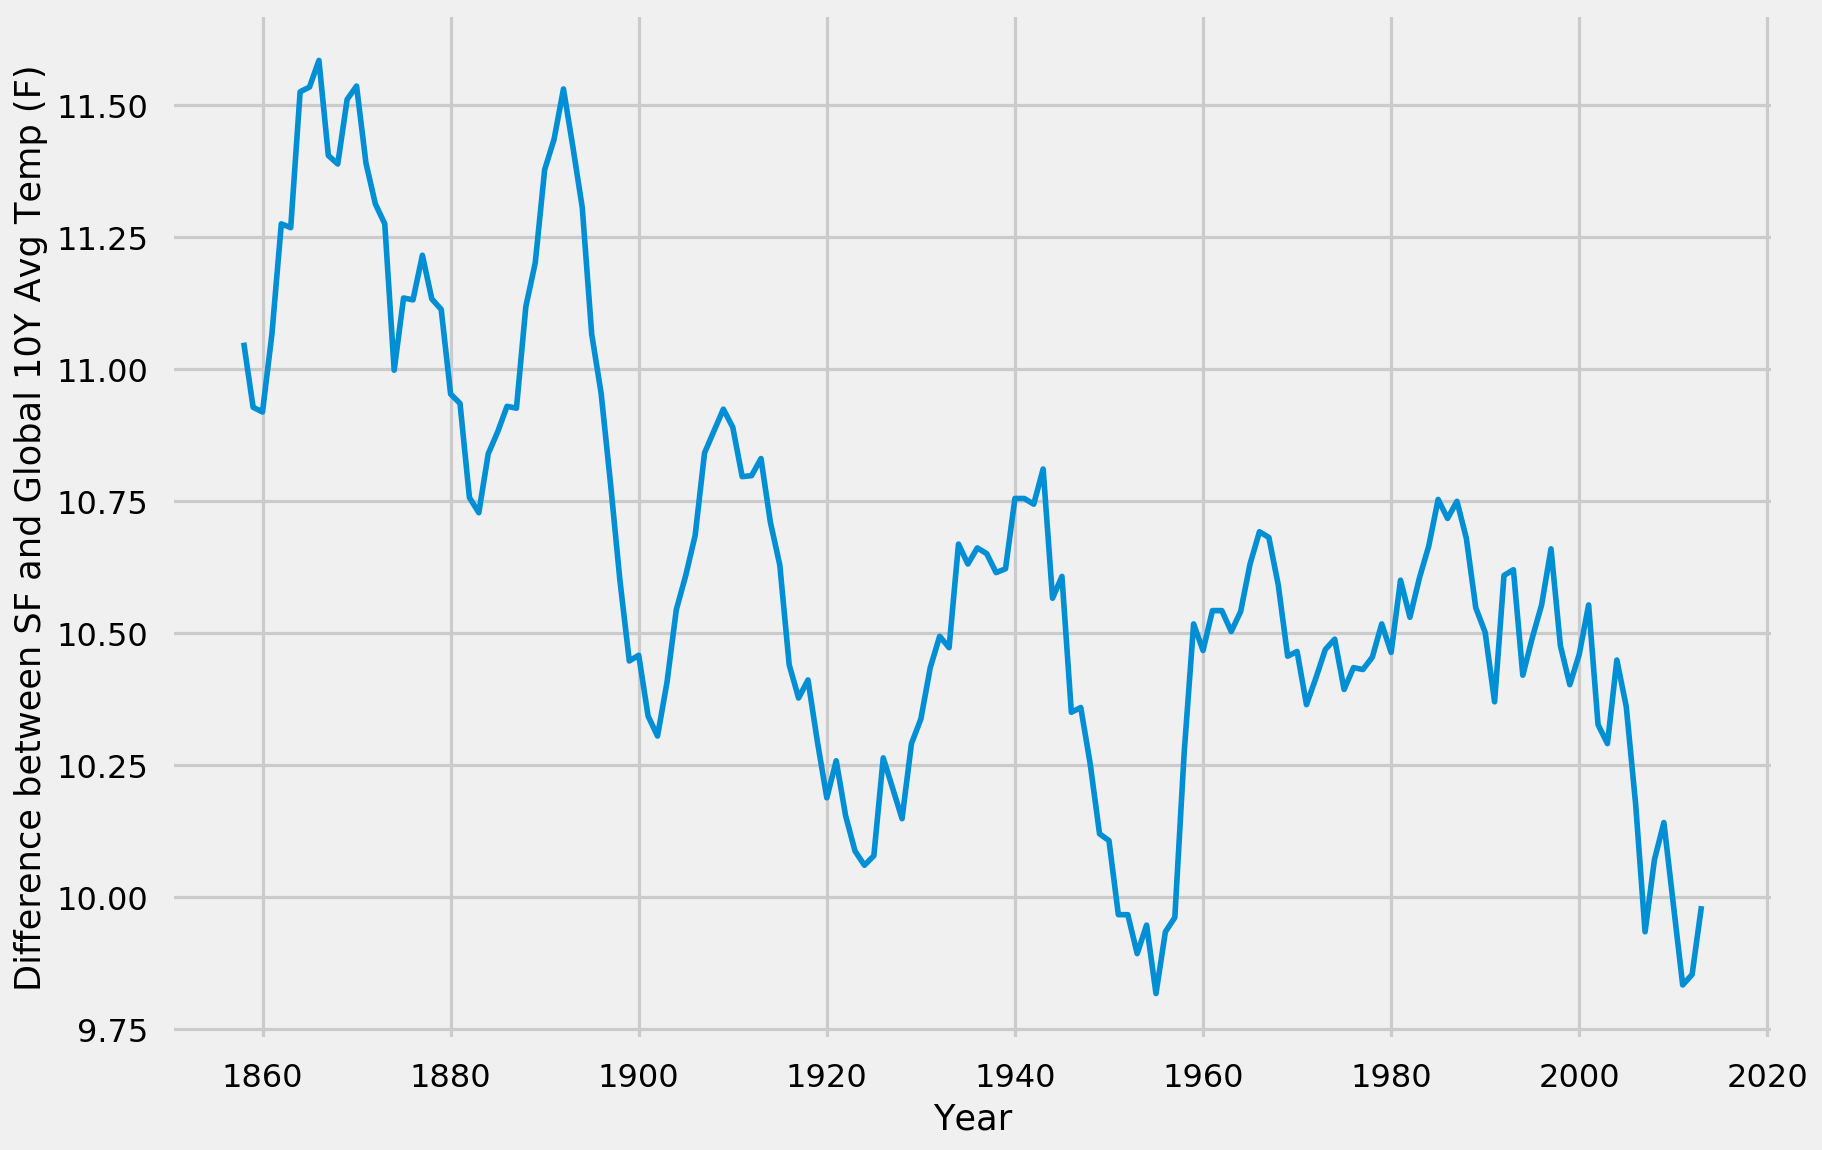

In [15]:
# Plot the difference between SF and global average temperatures
plt.plot(temps['avg_temp_sf'].rolling(window=10).mean() - 
         temps['avg_temp_glob'].rolling(window=10).mean())
plt.xlabel('Year')
plt.ylabel('Difference between SF and Global 10Y Avg Temp (F)')

Looking at the ten-year average, we can see that the trend is narrowing. Although both SF and global temperature averages are increasing, the global average seems to be increasing faster and therefore the gap between the two is narrowing.

What's the correlation coefficient for SF vs. global temperature?

In [16]:
temps['avg_temp_sf'].corr(temps['avg_temp_glob'])

0.5360381430194766

### How does San Francisco compare to global since 1975?

In [17]:
temps.tail()

,avg_temp_glob,avg_temp_sf
year,,
2011,49.136,58.100
2012,49.118,59.090
2013,49.298,61.214
2014,49.226,NaN
2015,49.694,NaN


I checked to see how recent the data is. I see that global is only through 2015 and SF is only through 2013. That means the 10-year averages I was plotting above for SF actually cover the years 2003-13, making them somewhat misleading.

When I examine the annual trends I can see both the global uptick since 1975 and an increase for SF, especially in the most recent year in the data set (2015) which is the hottest measured.

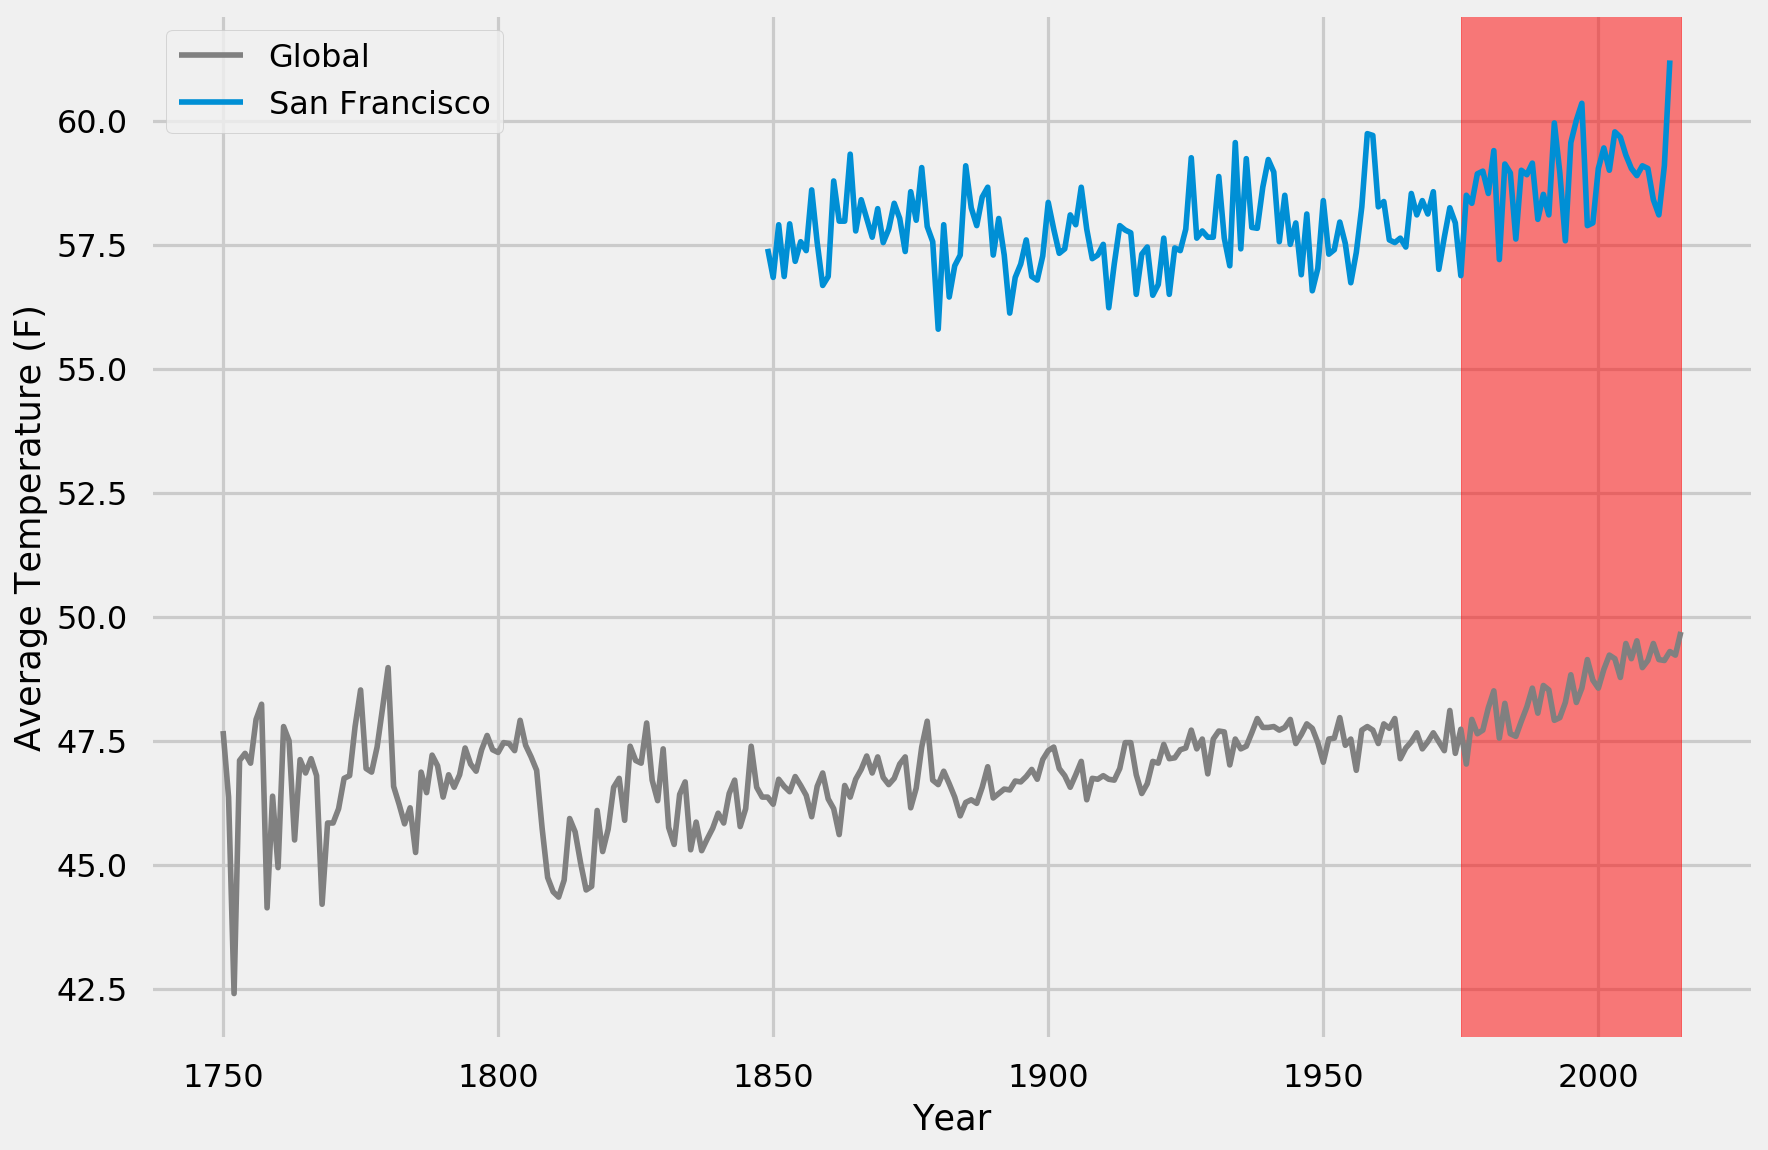

In [18]:
plt.plot(temps['avg_temp_glob'], color='gray', label='Global')
plt.plot(temps['avg_temp_sf'], label='San Francisco')
plt.xlabel('Year')
plt.ylabel('Average Temperature (F)')
plt.axvspan(1975, 2015, color='red', alpha=0.5)
plt.legend()
plt.show()

## Observations

1. **Is your city hotter or cooler on average compared to the global average? Has the difference been consistent over time?** _San Francisco is hotter on average than the global average. The difference has ranged from 9-13 degrees Fahrenheit, but this gap is narrowing in recent years to less than 10 degrees._
1. **How do the changes in your city’s temperatures over time compare to the changes in the global average?** _San Francisco is getting hotter, but at a slower rate than the global average._
1. **What does the overall trend look like? Is the world getting hotter or cooler? Has the trend been consistent over the last few hundred years?** _The world is getting hotter according to my plots. Since 1850, the global 50-year moving average has increased more than 2 degrees Fahrenheit. According to an ongoing temperature analysis conducted by scientists at NASA’s Goddard Institute for Space Studies (GISS), the average global temperature on Earth has increased by about 0.8 degrees Celsius (1.4 degree Fahrenheit) since 1880. Two-thirds of the warming has occurred since 1975, at a rate of roughly 0.15-0.20 degree Celsius per decade. (Source: [NASA](https://earthobservatory.nasa.gov/world-of-change/DecadalTemp)) The global trend is consistent with what I observed._
1. **What is the correlation coefficient?** _The correlation coefficient between SF and Global temperatures is 0.54. There is a medium positive correlation between the two values._
1. **Has most of San Francisco's temperature increase happened since 1975?** _I was intrigued that "two-thirds of the warming has occurred since 1975" and was curious if the same phenomenon was present in SF. I investigated that in the last section above. In my last 10-year average plot, it seemed that SF's average temperature has actually _declined_ since 1975. After digging deeper, I discovered that (a) SF data only goes through 2013, and (b) the ten year moving average disguised the effects of the significant increases in the past 3 years of the data set. This demonstrates one of the weaknesses of using moving averages: although it can make it easier to spot longer-term trends, it can also disguise dramatic increases or decreases in the data._